In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import random
import geopandas as gpd
from pyproj import *
from shapely.geometry import *
from cratersfd import *
%matplotlib inline

Load the data into a simple latitude and longitude projection on an oblate Moon.  Here, we load an ArcGIS shapefile into a GeoPandas GeoDataFrame of Shapely Polygon objects.  The example data are the count areas for Yue et al. (2020) on the Orientale ejecta.

In [2]:
lunar_crs = '+proj=longlat +a=1738100 +b=1736000 +no_defs'
regions = gpd.read_file('../data/AREA_Orientale.shp')
regions = regions.to_crs(lunar_crs)

To calculate an area, apply the calculate_area() function to a Polygon or MultiPolygon object.  This algorithm densifies the polygon by adding points in between vertices, then calculates the geodetic areas.  It efficiently and correctly calculates areas, including for large regions with irregular shapes.

In [3]:
orientale_areas = np.array([
    calculate_area(geom) for geom in regions.geometry
])
orientale_areas

array([243367.04204455, 208191.24594791, 140779.38328942, 268061.14208962,
       283837.94672072, 228000.70105061, 309450.60602018, 164685.48362337])

The calculate_area() function assumes the body is the moon.  To change it, pass a pyproj Geod object to the geod keyword argument.  Here is an example for Mars.

In [4]:
mars_geod = Geod(a=3396190., b=3376200.)
orientale_areas_if_they_were_on_mars = np.array([
    calculate_area(geom, geod=mars_geod) 
    for geom in regions.geometry
])
orientale_areas_if_they_were_on_mars

array([ 918530.59071102,  785726.57674623,  532288.60935473,
       1019500.37463715, 1083569.65532053,  868778.38942515,
       1167887.10810825,  622853.72558501])

Now, let's compare this to other methods.  Here's a line by line integration for area.  This is slower and limited by computational time, but it avoids the potential glitches of other methods.  Increase the ny parameter for the number of lines of latitude in the integration to increase the accuracy.  

In [5]:
def width_at(polygon, y):
    xmin, xmax = polygon.bounds[0], polygon.bounds[2]
    buffer = xmax - xmin / 5
    line = LineString([(xmin - buffer, y), (xmax + buffer, y)])
    
    intersection = polygon.intersection(line)

    if intersection.is_empty:
        return 0

    if intersection.geom_type == 'LineString':
        return intersection.length
    elif intersection.geom_type == 'MultiLineString':
        return sum(line.length for line in intersection.geoms)
    else:
        raise ValueError('Must be a LineString or a MultiLineString')

def integrated_area(polygon, ny):
    r_moon = 1738.1
    ymin, ymax = polygon.bounds[1], polygon.bounds[3]
    ypad = (ymax - ymin) / ny / 2
    y_array = np.linspace(ymin + ypad, ymax - ypad, ny)
    y_widths = np.array([width_at(polygon, y) for y in y_array])
    latdeg = math.pi * r_moon / 180
    y_widths_km = np.array([
        np.cos(np.radians(y)) * latdeg * w
        for y, w in zip(y_array, y_widths)
    ])
    y_areas = y_widths_km * (ymax - ymin) / ny * latdeg
    return y_areas.sum()

Calculates area by projection to an equal area projection, either cylindrical or sinusoidal.  Creates errors for irregular shapes, especially long, thin, concave shapes.

In [6]:
def projected_area(gdf, projection='sinusoidal'):
    sinusoidal = '+proj=sinu +a=1738100 +b=1736000 +lon_0=0 +units=m +no_defs'
    cylindrical = '+proj=cea +a=1738100 +b=1736000 +units=m +no_defs'
    if projection == 'sinusoidal':
        proj = sinusoidal
    else:
        proj = cylindrical
    gdf_proj = gdf.to_crs(proj)
    return gdf_proj.geometry.area / 10**6

Calculates the area from a local sinusoidal projection.

In [7]:
def local_sinusoidal_area(polygon):
    centroid = polygon.centroid
    sinusoidal_crs = (
        '+proj=sinu +a=1738100 +b=1736000 '
        '+lon_0=' + str(centroid.x) + ' +units=m +no_defs'
    )
    transformer = Transformer.from_crs(
        lunar_crs, sinusoidal_crs, always_xy=True
    )
    projected_coords = [
        transformer.transform(x, y) 
        for x, y in polygon.exterior.coords
    ]
    projected_polygon = Polygon(projected_coords)
    return projected_polygon.area / 10**6

Now we run the calculations.

In [8]:
sinusoidal_areas = projected_area(
    regions, projection='sinusoidal'
)
local_sinusoidal_areas = [
    local_sinusoidal_area(geom) for geom in regions.geometry
]
cylindrical_areas = projected_area(
    regions, projection='cylindrical'
)
integrated_areas = np.array([
    integrated_area(geom, ny=10000) 
    for geom in regions.geometry
])

Here are the results.

In [9]:
pd.DataFrame({
    'Dense Geodetic' : orientale_areas, 
    'Integrated' : integrated_areas, 
    'Cylindrical' : cylindrical_areas, 
    'Sinusoidal' : sinusoidal_areas,
    'Local Sinusoidal' : local_sinusoidal_areas
}).round(1)

,Dense Geodetic,Integrated,Cylindrical,Sinusoidal,Local Sinusoidal
0,243367.0,243371.6,243022.7,239589.5,240937.8
1,208191.2,208194.5,207545.9,202382.6,207605.0
2,140779.4,140798.1,140568.3,140062.4,140393.3
3,268061.1,268197.6,264881.7,268883.0,273785.4
4,283837.9,284050.5,288801.5,274399.4,272841.6
5,228000.7,228144.3,226342.2,236596.3,230983.3
6,309450.6,309455.3,308376.4,316487.4,308660.0
7,164685.5,164710.4,164486.8,164836.9,164181.2


When we use the integrated areas as a baseline, we see that the dense geodetic method is the closest, and the equal area methods deviate further, but not as much as the CraterTools areas.  The sinusoidal area projection has larger deviations from the integrated area than the cylindrical area, but the local sinusoidal projection has only slighly larger deviations than the cylindrical area.

In [10]:
pd.DataFrame({
    'CraterTools' : regions['Area'] / integrated_areas, 
    'Dense Geodetic' : orientale_areas / integrated_areas,  
    'Cylindrical' : cylindrical_areas / integrated_areas, 
    'Sinusoidal' : sinusoidal_areas / integrated_areas,
    'Local Sinusoidal' : local_sinusoidal_areas / integrated_areas
}).round(5)

,CraterTools,Dense Geodetic,Cylindrical,Sinusoidal,Local Sinusoidal
0,0.90100,0.99998,0.99857,0.98446,0.99000
1,0.91406,0.99998,0.99688,0.97208,0.99717
2,0.93686,0.99987,0.99837,0.99477,0.99712
3,0.93027,0.99949,0.98764,1.00256,1.02083
4,0.87480,0.99925,1.01673,0.96602,0.96054
5,0.91733,0.99937,0.99210,1.03705,1.01244
6,0.89553,0.99998,0.99651,1.02272,0.99743
7,0.92664,0.99985,0.99864,1.00077,0.99679


Each of the non-integrated area methods suffer from issues with calculating areas for irregular polygons.  Let's look at an example that reveals the problem: a thin wedge.

In [11]:
orientale_center = Point(-92.8, -19.4)
def get_wedge(angle1, angle2):
    global orientale_center
    x1 = orientale_center.x + math.cos(angle1) * 800
    y1 = orientale_center.y + math.sin(angle1) * 800
    point1 = Point(x1, y1)
    x2 = orientale_center.x + math.cos(angle2) * 800
    y2 = orientale_center.y + math.sin(angle2) * 800
    point2 = Point(x2, y2)
    wedge = Polygon([orientale_center, point1, point2])
    wedge_gdf = gpd.GeoDataFrame(geometry=[wedge], crs=lunar_crs)
    regions['overlap'] = regions.geometry.intersection(wedge)
    return regions['overlap']

Here, we look at two different versions.  Wedge B has an infinitessimally larger angle than Wedge A.  It shouldn't change the area, but it has a huge effect for some methods.

In [12]:
angle1 = 5.464978825595072
angle2a = 5.511627965
angle2b = 5.511627966

wedge_a = get_wedge(angle1, angle2a)
wedge_b = get_wedge(angle1, angle2b)

The dense geodetic area is still close to the integrated area (but very slightly lower).  The cylindrical area is notably lower, and the sinusoidal area is even lower.  The integrated and dense geodetic methods show the same areas for Wedge A and Wedge B, but both the equal area projection methods show different areas.  So what's going on?

In [13]:
print('Integrated Area:')
a = integrated_area(wedge_a.iloc[3], ny=10000)
b = integrated_area(wedge_b.iloc[3], ny=10000)
print(
    'Wedge A: ' + str(round(a, 1)) + '\n'
    'Wedge B: ' + str(round(b, 1)) + '\n'
)
print('Dense Geodetic Area:')
a = calculate_area(wedge_a.iloc[3], resolution=0.01)
b = calculate_area(wedge_b.iloc[3], resolution=0.01)
print(
    'Wedge A: ' + str(round(a, 1)) + '\n'
    'Wedge B: ' + str(round(b, 1)) + '\n'
)
print('Cylindrical Area:')
a = projected_area(wedge_a, projection='cylindrical').iloc[3]
b = projected_area(wedge_b, projection='cylindrical').iloc[3]
print(
    'Wedge A: ' + str(round(a, 1)) + '\n'
    'Wedge B: ' + str(round(b, 1)) + '\n'
)
print('Sinusoidal Area:')
a = projected_area(wedge_a, projection='sinusoidal').iloc[3]
b = projected_area(wedge_b, projection='sinusoidal').iloc[3]
print(
    'Wedge A: ' + str(round(a, 1)) + '\n'
    'Wedge B: ' + str(round(b, 1)) + '\n'
)
print('Local Sinusoidal Area:')
a = local_sinusoidal_area(wedge_a.iloc[3])
b = local_sinusoidal_area(wedge_b.iloc[3])
print(
    'Wedge A: ' + str(round(a, 1)) + '\n'
    'Wedge B: ' + str(round(b, 1)) + '\n'
)

Integrated Area:
Wedge A: 20135.3
Wedge B: 20135.3

Dense Geodetic Area:
Wedge A: 20122.3
Wedge B: 20122.3

Cylindrical Area:
Wedge A: 20625.1
Wedge B: 19920.6

Sinusoidal Area:
Wedge A: 19321.1
Wedge B: 19742.8

Local Sinusoidal Area:
Wedge A: 19003.3
Wedge B: 20447.2



The first thing that's difficult about this region is that it's long and thin.

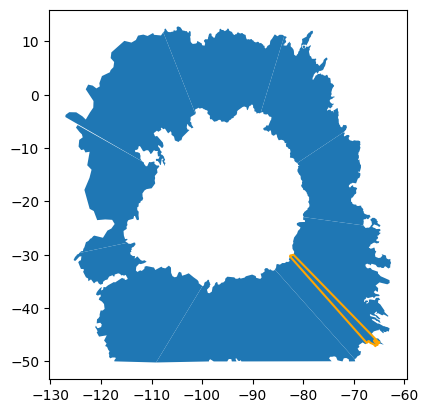

In [14]:
lon, lat = wedge_a.iloc[3].exterior.xy
regions.plot()
plt.plot(lon, lat, 'orange')

When we zoom in to the southeastern tip, we see that it also has concave points.  And we can see what the difference between Wedge A and Wedge B is.  Wedge A is infinitessimally below intersecting with a concave point on the edge of the region, which would add another concave point.  Wedge B has added that concave point.  All area calculation methods struggle with concave points.  Equal area methods add further distortions by distorting the shape, amplifying the problems with irregular shapes.

(-47.5, -44.0)

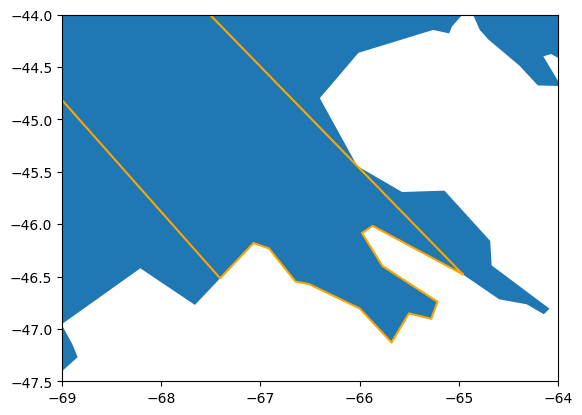

In [15]:
lon, lat = wedge_a.iloc[3].exterior.xy
regions.plot()
plt.plot(lon, lat, 'orange')
plt.xlim([-69, -64])
plt.ylim([-47.5, -44])

The dense geodetic method avoids this by densifying the polygons by adding more points.  If we raise the resolution parameter to 1000, effectively eliminating densification, we can see that this method now finds incorrect areas and different areas for Wedge A and Wedge B.

In [16]:
a = lunar_area(wedge_a.iloc[3], resolution=1000.0)
b = lunar_area(wedge_b.iloc[3], resolution=1000.0)
a, b

(18400.23665234566, 20268.294473601996)